In [242]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [243]:
# Utility Methods

def filter_columns(dataframe: pd.DataFrame, dtype, exclude_columns=None):
    """ Helper method to select DataFrame columns by dtype
    and select columns to drop. """
    if exclude_columns is None:
        exclude_columns = []
    return [
        col for col in dataframe.select_dtypes(include=[dtype]).columns
        if col not in exclude_columns
    ]

In [407]:
class Notebook:
    def __init__(self, csv):
        self.dataframe = pd.read_csv('pre_transform_data.csv')
       
    # ------  CSV  F I L E S  ------ #  ^
    
        # failure_data
        # reformatted_data
        # pre_transform_data     -->     imputed_data
        # transformed_failure_data

    # --------- Utility Methods ---------- #

    def _create_subplots(self, num_plots, cols=3, subplot_size=(5, 5)):
        """Helper method to handle subplot creation."""
        rows = (num_plots // cols) + (num_plots % cols > 0)
        plt.figure(figsize=(subplot_size[0] * cols, subplot_size[1] * rows))
        return rows, cols

    # General multi-use line plot method
    def plot_line_chart(self, x_values, y_values, title="Line Chart", group_columns=None, x_label=None, y_label=None):
        """
        Generic line plot method to visualise data, with optional support for grouping.

        Parameters:
            x_values (pd.Index or array-like): The values to plot on the x-axis.
            y_values (pd.Series or dict): The values to plot on the y-axis. Can be a single series or a dictionary for multiple groups.
            title (str, optional): Title for the plot. Default is "Line Chart".
            group_columns (list, optional): List of group labels for plotting multiple lines.
            x_label (str, optional): Label for the x-axis. Default is None, which uses the x_values label.
            y_label (str, optional): Label for the y-axis. Default is None, which uses the y_values label.
        """
        plt.figure(figsize=(10, 6))
        if group_columns is not None:
            # Plotting multiple lines for each group
            for group in group_columns:
                plt.plot(
                    x_values,
                    y_values[group],
                    marker='o',
                    linestyle='-',
                    label=f'{group}'
                )
            plt.legend(title=group_columns.name)
        else:
            # Plotting a single line
            plt.plot(
                x_values,
                y_values,
                marker='o',
                linestyle='-',
                color='red'
            )
        plt.xticks(rotation=45, ha='right')
        plt.title(title)
        plt.xlabel(x_label if x_label else str(x_values))
        plt.ylabel(y_label if y_label else str(y_values))
        plt.tight_layout()
        plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        plt.show()


    def auto_bin_width(self, data, num_bins=36):
        """
        Calculate the bin width for a histogram using a custom approach with a specified number of bins,
        rounding to the nearest significant figure (order of magnitude).
        
        Parameters:
        - data (array-like): The data for which to calculate the bin width.
        - num_bins (int, optional): The number of bins to use for the calculation. Default is 36.
        
        Returns:
        - float: The computed bin width.
        """
        data = np.asarray(data)
        n = len(data)
    
        if n < 2:
            raise ValueError("Data must contain at least two data points.")
        
        # Use the specified number of bins
        data_range = np.max(data) - np.min(data)

        print(f"\nData range: {data_range}")
    
        # Calculate bin width
        bin_width = data_range / num_bins

        print(f"Initial bin width: {bin_width}")
    
        # Round the bin width to the nearest significant figure
        if bin_width == 0:
            raise ValueError("Bin width cannot be 0")

        # Determine the order of magnitude of the value
        order_of_magnitude = 10 ** (np.floor(np.log10(abs(bin_width))))
        # Round to the nearest significant figure
        rounded_bin_width = round(bin_width / order_of_magnitude) * order_of_magnitude

        # If rounding results in zero, return a small but non-zero value
        if rounded_bin_width == 0:
            rounded_bin_width = bin_width

        # Remove trailing .0 if the value is an integer
        if rounded_bin_width.is_integer():
            rounded_bin_width = int(rounded_bin_width)

        print(f"Rounded bin width: {rounded_bin_width}")
    
        return rounded_bin_width

    def failure_rate_analysis(self, dataframe, selected_column, target_column, group_column=None):
        """
        Divide the selected column values into bins and calculate the failure rate
        within each bin. Visualise the failure rate against the selected column
        to identify a recommended maximum value. Optionally, plot separate lines for different groups.

        Parameters:
            dataframe (pd.DataFrame): The DataFrame containing the data.
            selected_column (str): The column to divide into bins (e.g., 'Torque [Nm]').
            target_column (str): The target column indicating failures (e.g., 'HDF').
            group_column (str, optional): The column to group by (e.g., 'Type').
        """
        # Calculate bin width using the auto_bin_width method
        bin_width = self.auto_bin_width(dataframe[selected_column])

        # Creating bins with the calculated width
        dataframe['Selected Bin'] = pd.cut(
            dataframe[selected_column],
            bins=np.arange(0, dataframe[selected_column].max() + bin_width, bin_width).astype(int) if isinstance(bin_width, int) else np.arange(0, dataframe[selected_column].max() + bin_width, bin_width),
            right=False  # Ensures the bins are left-closed, right-open
        )

        if group_column:
            # Group by 'Selected Bin' and 'group_column' and calculate failure rate for each group
            grouped = dataframe.groupby(['Selected Bin', group_column])[target_column].agg(['sum', 'size'])
            grouped['failure_rate'] = (grouped['sum'] / grouped['size']) * 100
            failure_rate = grouped['failure_rate'].unstack(fill_value=0)

            # Plotting the failure rate for each group
            self.plot_line_chart(
                x_values=failure_rate.index.astype(str),
                y_values=failure_rate,
                title=(f'Failure Rate Analysis by {group_column}'),
                group_columns=failure_rate.columns,
                x_label=f'{selected_column} Bins',
                y_label=f'{target_column} Rate (%)'
            )
        else:
            # Calculating the total count and failure count for each bin
            bin_failure_counts = dataframe.groupby('Selected Bin')[target_column].sum()
            bin_total_counts = dataframe.groupby('Selected Bin').size()
            # Calculate failure rate in percentage
            failure_rate = (bin_failure_counts / bin_total_counts) * 100

            # Plotting failure rate for each bin to identify trends
            self.plot_line_chart(
                x_values=failure_rate.index.astype(str),
                y_values=failure_rate,
                title='Failure Rate Analysis',
                x_label=f'{selected_column} Bins',
                y_label=f'{target_column} Rate (%)'
            )

        # Remove 'Selected Bin' column after analysis
        dataframe.drop(columns=['Selected Bin'], inplace=True)

In [408]:
nb = Notebook('pre_transform_data.csv')


Data range: 8.100000000000023
Initial bin width: 0.22500000000000064
Rounded bin width: 0.2


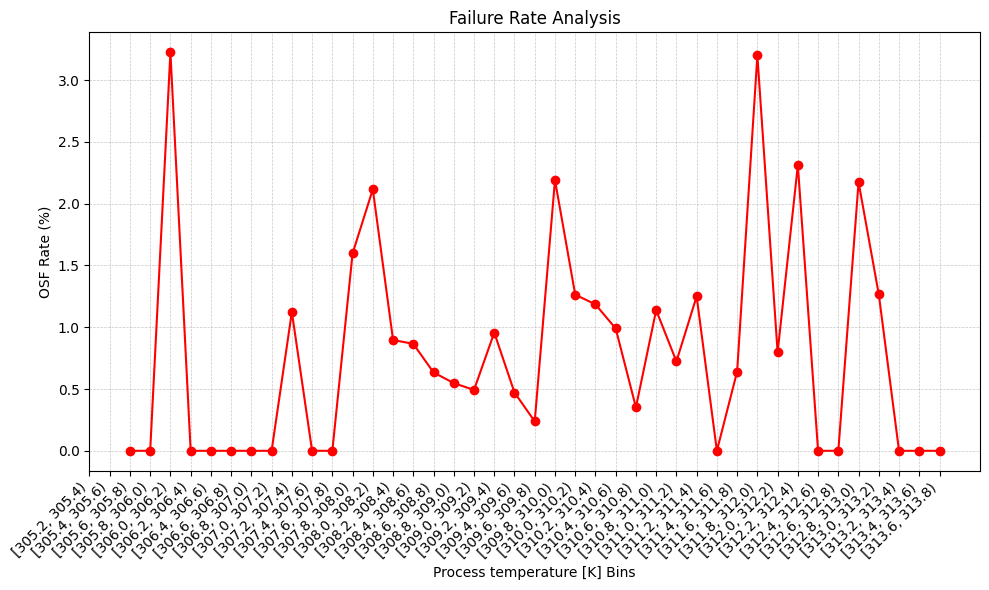

In [414]:
# Assuming Plotter class is instantiated with the data
columns_to_plot = ['Torque [Nm]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Air temperature [K]', 'Tool wear [min]']

nb.failure_rate_analysis(nb.dataframe, selected_column='Process temperature [K]', target_column='OSF')



In [226]:
    # General multi-use line plot method
    def plot_line_chart(self, x_values, y_values, title="Line Chart", group_columns=None, x_label=None, y_label=None):
        """
        Generic line plot method to visualise data, with optional support for grouping.

        Parameters:
            x_values (pd.Index or array-like): The values to plot on the x-axis.
            y_values (pd.Series or dict): The values to plot on the y-axis. Can be a single series or a dictionary for multiple groups.
            title (str, optional): Title for the plot. Default is "Line Chart".
            group_columns (list, optional): List of group labels for plotting multiple lines.
            x_label (str, optional): Label for the x-axis. Default is None, which uses the x_values label.
            y_label (str, optional): Label for the y-axis. Default is None, which uses the y_values label.
        """
        plt.figure(figsize=(10, 6))
        if group_columns is not None:
            # Plotting multiple lines for each group
            for group in group_columns:
                plt.plot(
                    x_values,
                    y_values[group],
                    marker='o',
                    linestyle='-',
                    label=f'{group}'
                )
            plt.legend(title="Groups")
        else:
            # Plotting a single line
            plt.plot(
                x_values,
                y_values,
                marker='o',
                linestyle='-',
                color='red'
            )
        plt.xticks(rotation=45, ha='right')
        plt.title(title)
        plt.xlabel(x_label if x_label else str(x_values))
        plt.ylabel(y_label if y_label else str(y_values))
        plt.tight_layout()
        plt.grid(True)
        plt.show()

    # Method to calculate bin width using a custom approach
    def auto_bin_width(self, data, num_bins=36):
        """
        Calculate the bin width for a histogram using a custom approach with a specified number of bins,
        rounding to the nearest significant figure (order of magnitude).
        
        Parameters:
        - data (array-like): The data for which to calculate the bin width.
        - num_bins (int, optional): The number of bins to use for the calculation. Default is 36.
        
        Returns:
        - float: The computed bin width.
        """
        data = np.asarray(data)
        n = len(data)
    
        if n < 2:
            raise ValueError("Data must contain at least two data points.")
        
        # Use the specified number of bins
        data_range = np.max(data) - np.min(data)

        print(f"\nData range: {data_range}")
    
        # Calculate bin width
        bin_width = data_range / num_bins

        print(f"Initial bin width: {bin_width}")
    
        # Round the bin width to the nearest significant figure
        if bin_width == 0:
            raise ValueError("Bin width is zero; returning zero.")
        # Determine the order of magnitude of the value
        order_of_magnitude = 10 ** (np.floor(np.log10(abs(bin_width))))
        # Round to the nearest significant figure
        rounded_bin_width = round(bin_width / order_of_magnitude) * order_of_magnitude
        
        # If rounding results in zero, ensure we return a small but non-zero value
        if rounded_bin_width == 0:
            rounded_bin_width = bin_width
        
        # Remove trailing .0 if the value is effectively an integer
        if rounded_bin_width.is_integer():
            rounded_bin_width = int(rounded_bin_width)

        print(f"Rounded bin width: {rounded_bin_width}")
    
        return rounded_bin_width

    # Core failure rate analysis method
    def failure_rate_analysis(self, dataframe, selected_column, target_column):
        """
        Divide the selected column values into bins and calculate the failure rate
        within each bin. Visualise the failure rate against the selected column
        to identify a recommended maximum value.

        Parameters:
            dataframe (pd.DataFrame): The DataFrame containing the data.
            selected_column (str): The column to divide into bins (e.g., 'Torque [Nm]').
            target_column (str): The target column indicating failures (e.g., 'HDF').
        """
        # Calculate bin width using the auto_bin_width method
        bin_width = self.auto_bin_width(dataframe[selected_column])

        # Creating bins with the calculated width
        dataframe['Selected Bin'] = pd.cut(
            dataframe[selected_column],
            bins=np.arange(0, dataframe[selected_column].max() + bin_width, bin_width).astype(int) if isinstance(bin_width, int) else np.arange(0, dataframe[selected_column].max() + bin_width, bin_width),
            right=False  # Ensures the bins are left-closed, right-open
        )

        # Calculating the total count and failure count for each bin
        bin_failure_counts = dataframe.groupby('Selected Bin')[target_column].sum()
        bin_total_counts = dataframe.groupby('Selected Bin').size()
        # Calculate failure rate in percentage
        failure_rate = (bin_failure_counts / bin_total_counts) * 100

        # Plotting failure rate for each bin to identify trends
        self.plot_line_chart(
            x_values=failure_rate.index.astype(str),
            y_values=failure_rate,
            title='Failure Rate Analysis',
            x_label=f'{selected_column} Bins',
            y_label=f'{target_column} Failure Rate (%)'
        )

        # Remove 'Selected Bin' column after analysis
        dataframe.drop(columns=['Selected Bin'], inplace=True)


Data range: 72.8
Initial bin width: 2.022222222222222

Data range: 1718
Initial bin width: 47.72222222222222

Rounded Torque data bin width: 2.0
Rounded Rotational data bin width: 50.0


In [168]:
'Torque [Nm]'
'Rotational speed [rpm]'

'Torque [Nm]'

In [ ]:
# Example usage
torque_data = nb.dataframe['Torque [Nm]']
rotational_data = nb.dataframe['Rotational speed [rpm]']